In [1]:
# %pip install -r requirements.txt

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


2024-10-26 22:59:35.620437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Setup
The first step is to import the necessary libraries and load the data and set the configuration.

In [3]:
def load_images_from_folder(folder):
    files = [f for f in os.listdir(os.path.join(f'data', 'images', folder)) if os.path.isfile(os.path.join(f'data', 'images', folder, f))]
    return tf.data.Dataset.from_tensor_slices(files)

In [4]:
validation_data = load_images_from_folder('val')
training_data = load_images_from_folder('train')


In [5]:
train_length = len(training_data) # How many images are in the training set
validation_length = len(validation_data) # How many images are in the validation set
print(f'train_length: {train_length}')
batch_size = 8 # How many images are in one batch (the model will be trained on this many images at once), higher values will make the training faster but less stable and more memory-intensive
learning_rate = 0.001 # How fast the model learns, higher values will make the model learn faster but might make it less stable. We will use a LearningRateScheduler to decrease the learning rate over time
buffer_size = 3000 # How many images are stored in memory, higher values will make the training faster but more memory-intensive
steps_per_epoch = train_length // batch_size # How many batches are in one epoch
image_size = (400, 400) # The size of the images the model will be trained on, higher values will make the model more accurate but will require more data, memory and time
max_num_boxes = 3  # How many boxes are in one image
threshold = 0.5 # The threshold for displaying the bounding boxes. Does not affect the model training
seed = 420 # The seed for the random number generator, this will make the training reproducible
epochs = 64 # How many times the model will see the whole dataset, we stop the training early if the model stops improving
model_version = 'v0_2' # The version of the model, this will be used to save the model


train_length: 13386


- v0_1: initial training, verify the model [:-20] not trained, (256, 256), bz 8
- v0_2: allowed all layers to be trained, (400, 400), 8

In [6]:
def parse_label_line(line):
    parts = tf.strings.split(line)
    # Filter out empty lines
    if tf.equal(tf.size(parts), 0):
        return tf.constant([0.0, 0.0, 0.0, 0.0])
    
    parts = tf.strings.to_number(parts, out_type=tf.float32)
    # class_id = parts[0]
    center_x = parts[1]
    center_y = parts[2]
    width = parts[3]
    height = parts[4]

    # Convert (center_x, center_y, width, height) to (x_min, y_min, x_max, y_max)
    x_min = center_x - (width / 2.0)
    y_min = center_y - (height / 2.0)
    x_max = center_x + (width / 2.0)
    y_max = center_y + (height / 2.0)

    # Return bounding box tensor and class ID separately
    return tf.stack([x_min, y_min, x_max, y_max])

def parse_image_and_label(image_path, label_path):
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)  # Adjust based on your model's input size
    image = tf.cast(image, tf.float32) / 255.0

    # Read the label file
    label_file_content = tf.io.read_file(label_path)
    label_lines = tf.strings.split(label_file_content, '\n')

    # Map each label line to bounding box coordinates
    bbox_labels = tf.map_fn(parse_label_line, label_lines, dtype=tf.float32)

    # Pad or truncate bounding boxes to ensure a fixed number of bounding boxes (max_num_boxes)
    num_boxes = tf.shape(bbox_labels)[0]
    padding_value = tf.maximum(0, max_num_boxes - num_boxes)
    bbox_labels = tf.cond(
        padding_value == 0,
        lambda: bbox_labels[:max_num_boxes],  # Truncate if there are too many boxes
        lambda: tf.pad(bbox_labels, [[0, padding_value], [0, 0]])  # Pad if too few boxes
    )

    confidence_labels = tf.ones([tf.minimum(num_boxes, max_num_boxes)])
    confidence_labels = tf.pad(confidence_labels, [[0, padding_value]])

    return image, {'bbox_output': bbox_labels, 'confidence_output': confidence_labels}

def create_dataset(data_dir):
    image_dir = os.path.join('data', 'images', data_dir)
    label_dir = os.path.join('data', 'labels', data_dir)

    image_file_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    label_file_paths = sorted([os.path.join(label_dir, fname[:-4] + '.txt') for fname in os.listdir(image_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    return dataset.map(parse_image_and_label)

# Create the datasets
train_images = create_dataset('train')
test_images = create_dataset('val')


Instructions for updating:
Use fn_output_signature instead


In [7]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size, seed=seed)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)


In [8]:

def display(image, labels, predictions=None):
    plt.figure(figsize=(5, 5))

    # Convert the image to displayable format
    img = tf.keras.utils.array_to_img(image)
    plt.imshow(img)
    plt.axis('off')

    ax = plt.gca()  # Get current axis
    bboxes, confidences = labels['bbox_output'], labels['confidence_output']
    for bbox, confidence in zip(bboxes, confidences):
        if confidence == 0:
            continue
        # bbox format: [x_min, y_min, x_max, y_max, class_id]
        x_min, y_min, x_max, y_max = bbox[:4]
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
        # Create a rectangle patch
        rect = patches.Rectangle((x_min * img.width, y_min * img.height), 
                                  width * img.width, 
                                  height * img.height, 
                                  linewidth=2, 
                                  edgecolor='r', 
                                  facecolor='none')
        ax.add_patch(rect)
    if predictions is not None:
      predicted_boxes = predictions[0][0]  # Assuming the model has multiple bounding box predictions
      confidence_scores = predictions[1][0]  # Get confidence scores
      for bbox, confidence in zip(predicted_boxes, confidence_scores):
          if confidence < threshold:
              continue
          # bbox format: [x_min, y_min, x_max, y_max, class_id]
          x_min, y_min, x_max, y_max = bbox[:4]
          # Calculate width and height
          width = x_max - x_min
          height = y_max - y_min
          # Create a rectangle patch
          rect = patches.Rectangle((x_min * img.width, y_min * img.height), 
                                    width * img.width, 
                                    height * img.height, 
                                    linewidth=2, 
                                    edgecolor='b', 
                                    facecolor='none')
          ax.add_patch(rect)
          plt.text(x_min * img.width, y_min * img.height, f'{confidence:.2f}', backgroundcolor='b', color='w')
    plt.show()


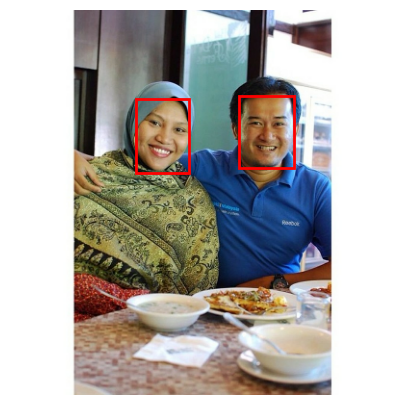

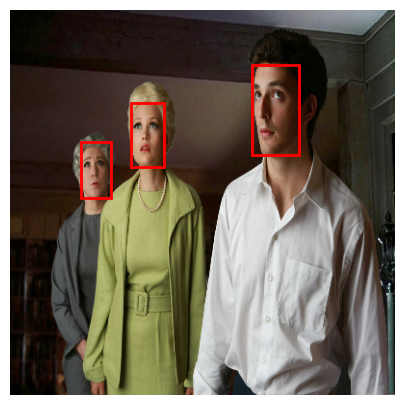

In [9]:
for image, labels in train_images.take(2):
  sample_image, sample_labels = image, labels
  display(image, labels)

In [10]:
def create_object_detection_model(input_shape=(image_size[0], image_size[1], 3)):
    # Define the input
    input_image = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # Freeze part of the base model to retain pre-trained weights
    base_model.trainable = True
    # Freeze all layers except the top few layers
    # for layer in base_model.layers[:-20]:  # Adjust this number as needed
    #     layer.trainable = False

    x = base_model(input_image)

    # Add global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layer to predict bounding boxes (4 outputs for x_min, y_min, x_max, y_max) for each box * max_num_boxes
    bbox_output = layers.Dense(max_num_boxes * 4, activation='sigmoid')(x)
    bbox_output = layers.Reshape((max_num_boxes, 4), name='bbox_output')(bbox_output)
    confidence_output = layers.Dense(max_num_boxes, activation='sigmoid', name='confidence_output')(x)

    # Create the model
    model = models.Model(inputs=input_image, outputs=[bbox_output, confidence_output])

    return model


In [11]:
def iou_loss(y_true, y_pred):
    # Calculate the intersection
    x_min_inter = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y_min_inter = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x_max_inter = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y_max_inter = tf.minimum(y_true[..., 3], y_pred[..., 3])

    intersection = tf.maximum(x_max_inter - x_min_inter, 0) * tf.maximum(y_max_inter - y_min_inter, 0)

    # Calculate the union
    true_area = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    pred_area = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])

    union = true_area + pred_area - intersection

    # Calculate IoU
    iou = intersection / tf.maximum(union, 1e-6)

    # IoU loss (you want to maximize IoU, hence minimizing its inverse)
    return 1 - iou

def combined_iou_overlap_loss(y_true, y_pred):
    # Calculate IoU as before
    iou_loss_value = iou_loss(y_true, y_pred)

    # Compute overlap penalty (based on the size of overlapping areas)
    x_min_inter = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y_min_inter = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x_max_inter = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y_max_inter = tf.minimum(y_true[..., 3], y_pred[..., 3])
    
    intersection = tf.maximum(x_max_inter - x_min_inter, 0) * tf.maximum(y_max_inter - y_min_inter, 0)
    overlap_penalty = tf.reduce_sum(intersection)
    
    # Combine IoU loss and overlap penalty
    combined_loss = iou_loss_value + 0.1 * overlap_penalty  # 0.1 is a scaling factor, adjust as needed
    
    return combined_loss


In [12]:
model = create_object_detection_model()

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss={
                  'bbox_output': combined_iou_overlap_loss,
                  'confidence_output': 'binary_crossentropy'  # For confidence scores
              },
              metrics={
                  'bbox_output': 'mse',
                  'confidence_output': 'accuracy'
              })

# model.summary()

In [13]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, bboxes in dataset.take(num):
            predictions = model.predict(image)  # Predict bounding boxes
            display(image, bboxes, predictions)  # Visualize image with predicted bboxes
    else:
        predictions = model.predict(sample_image[tf.newaxis, ...])  # Predict bounding boxes on a sample image
        display(sample_image, sample_labels, predictions)  # Visualize sample image with predicted bboxes


1/1 [==============================] - 1s 903ms/step


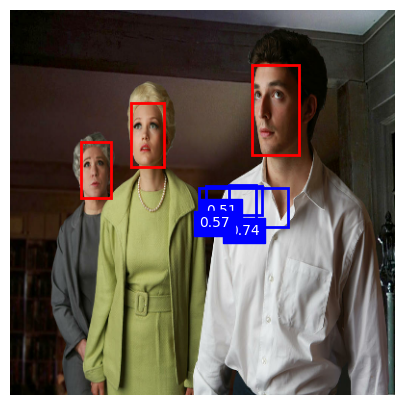

In [14]:
show_predictions()


In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [16]:
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5 
    return lr

1/1 [==============================] - 0s 154ms/step


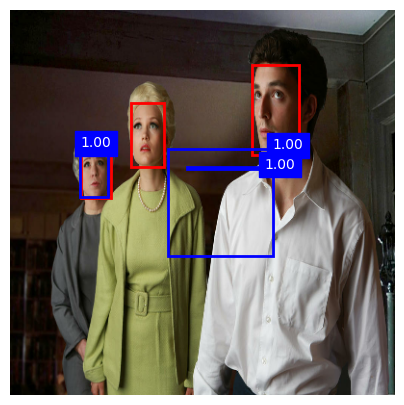


Sample Prediction after epoch 18

1673/1673 [==============================] - 4372s 3s/step - loss: 0.8597 - bbox_output_loss: 0.8452 - confidence_output_loss: 0.0146 - bbox_output_mse: 0.1196 - confidence_output_accuracy: 0.0000e+00 - val_loss: 0.9787 - val_bbox_output_loss: 0.8546 - val_confidence_output_loss: 0.1241 - val_bbox_output_mse: 0.1213 - val_confidence_output_accuracy: 0.0000e+00 - lr: 7.8125e-06


In [17]:
validation_subsplits = 3
validation_steps = validation_length//batch_size//validation_subsplits

lr_scheduler = LearningRateScheduler(lr_schedule)

checkpoint = ModelCheckpoint(filepath=f'best_model_{model_version}.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_history = model.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), lr_scheduler, checkpoint, early_stopping])


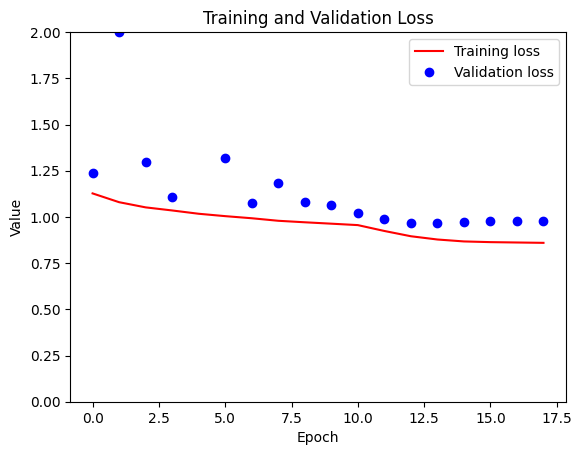

In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
# accuracy = model_history.history['accuracy']
# val_accuracy = model_history.history['val_accuracy']

if len(val_loss) < len(loss):
    val_loss += [val_loss[-1]] * (len(loss) - len(val_loss))
# if len(val_accuracy) < len(accuracy):
#     val_accuracy += [val_accuracy[-1]] * (len(accuracy) - len(val_accuracy))

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
# plt.plot(model_history.epoch, accuracy, 'r--', label='Training accuracy')
# plt.plot(model_history.epoch, val_accuracy, 'bs', label='Validation accuracy')
plt.title('Training and Validation Loss')
# plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 2])
plt.legend()
plt.show()


1/1 [==============================] - 0s 90ms/step


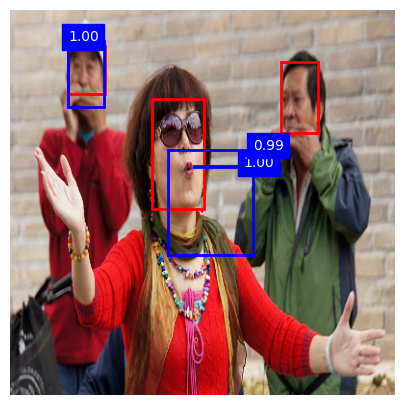

1/1 [==============================] - 0s 84ms/step


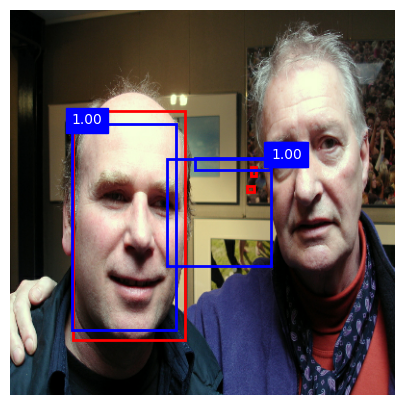

1/1 [==============================] - 0s 88ms/step


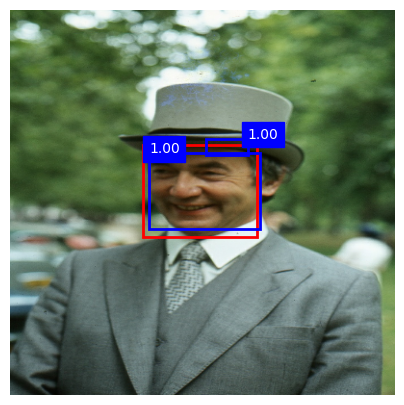

1/1 [==============================] - 0s 88ms/step


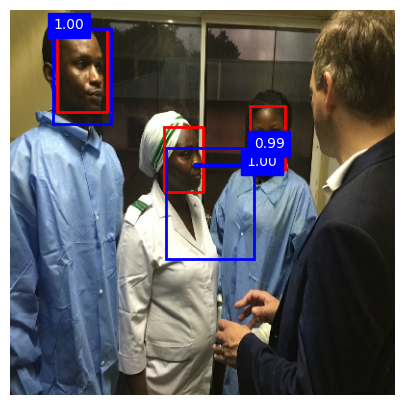

1/1 [==============================] - 0s 85ms/step


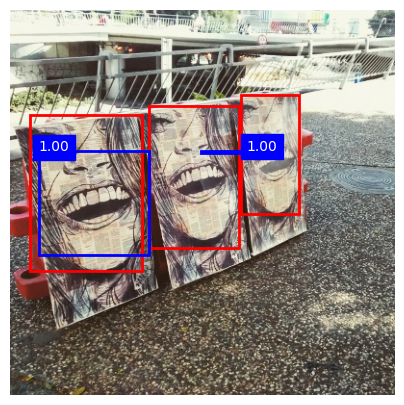

In [19]:
for image, labels in test_images.take(5):
  sample_image, sample_labels = image, labels
  show_predictions()

In [20]:
model.save(f'models/{model_version}.keras')


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(f'models/{model_version}.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp6hhfvgyc/assets


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp6hhfvgyc/assets
2024-10-27 20:41:37.587479: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-27 20:41:37.587728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-27 20:41:37.612326: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp6hhfvgyc
2024-10-27 20:41:37.649739: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-27 20:41:37.649756: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp6hhfvgyc
2024-10-27 20:41:37.723947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-27 20:41:37.760401: I tensorflow/cc/saved_model/load